In [1]:
# Process cluster hyperparamsweep v1

In [1]:
from glob import glob
import sys 
import torch
import numpy as np
sys.path.append("..")
files = glob("../study/study/*_0.pkl")

In [3]:
accs = list()
params = list()
for f in files:
    d = torch.load(f)
    acc = d["accuracies"][-1]
    lr = d["params"]
    accs.append(acc)
    pdict = dict(d["params"])
    pdict.pop("name")
    params.append(list(map(float, pdict.values())))
accs = np.asarray(accs)
params = np.asarray(params)
print(params.shape)

(0,)


In [3]:
import matplotlib.pyplot as plt
mask = params[:, 5] == 6
mask = np.logical_and(mask, params[:, 1] < 1e-4)
mask = np.logical_and(mask, params[:, 2] > 0.3)
plt.plot(params[mask, 0], accs[mask], 'r.')

TypeError: list indices must be integers or slices, not tuple

(array([217., 225.,   0.,   0., 231.,   0.,   0.,   0.,   0.,  84.]),
 array([0.0001    , 0.0001456 , 0.00019121, 0.00023681, 0.00028241,
        0.00032801, 0.00037362, 0.00041922, 0.00046482, 0.00051043,
        0.00055603]),
 <BarContainer object of 10 artists>)

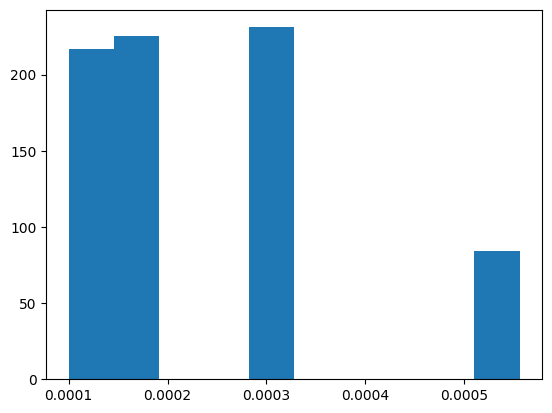

In [89]:
plt.hist(params[:, 0])

Loading 115 files from ../raw_data/DataDavid/UVVIS/*.asc
Loading 360 files from ../raw_data/DataHenry23/Perkin/New_*/*.asc
Loading 43 files from ../raw_data/DataJulie/07_09_spectro/**/*.asc
Loading 24 files from ../raw_data/DataJulie/14_09_2023/*.asc
Loading 16 files from ../raw_data/DataJulie/11_09_2023/*.asc
Loading 13 files from ../raw_data/DataJulie/14_09_2023_histo/*.asc
Loading 21 files from ../raw_data/DataJulie/historique/*.asc


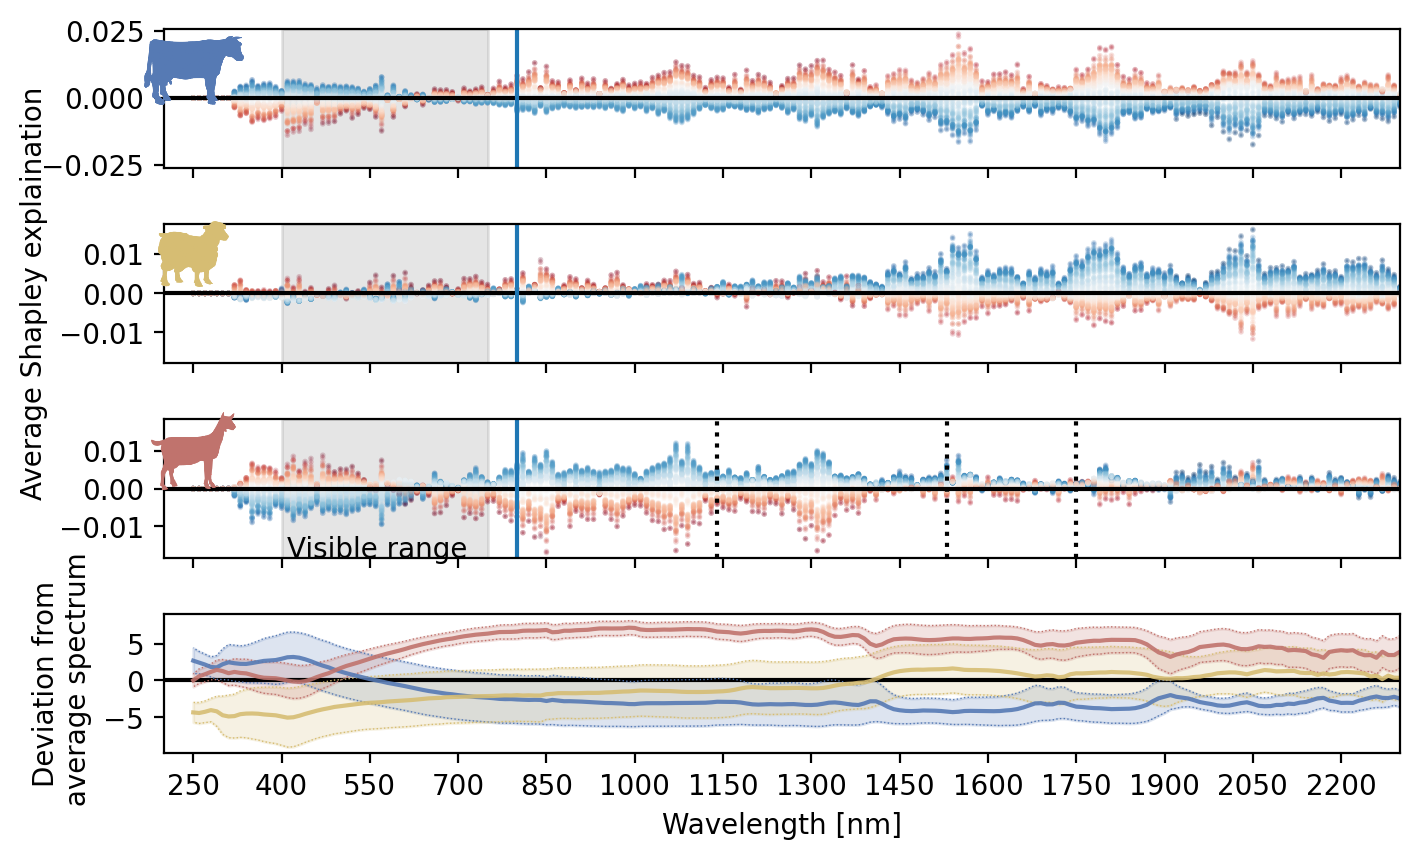

In [58]:
import sys
sys.path.append("..")
import numpy as np
from toolkit.dataset import load_spectral_data, dataset_dict_to_dense, normalize_spectra
dataset_dict = load_spectral_data([
    "../raw_data/DataDavid/UVVIS/*.asc",
    "../raw_data/DataHenry23/Perkin/New_*/*.asc",
    "../raw_data/DataJulie/07_09_spectro/**/*.asc",
    "../raw_data/DataJulie/14_09_2023/*.asc",
    "../raw_data/DataJulie/11_09_2023/*.asc",
    "../raw_data/DataJulie/14_09_2023_histo/*.asc",
    "../raw_data/DataJulie/historique/*.asc",
], verbose=True)

X, Y = dataset_dict_to_dense(dataset_dict)
#X = normalize_spectra(X)
valid_mask = np.logical_or(Y[:, 0] == 13, Y[:, 0] == 12)
Xv = X[valid_mask]
Yv = Y[valid_mask]
X = X[~valid_mask]
Y = Y[~valid_mask]

root = "../shap_stats/"
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
files = glob(f"{root}/*.npz", recursive=True)
test_images = list()
shap_values = list()
accs = list()
for f in files:
    d = np.load(f)
    test_images.append(d["test_images"])
    shap_values.append(d["shap_values"])
    accs.append(d["acc"])
accs = np.asarray(accs)
test_images = np.asarray(test_images).mean(axis=0)
#test_images -= test_images.mean(axis=0)
#test_images /= test_images.max(axis=0)
#print(test_images.shape)
test_images = test_images.reshape(119*206)
raw_shaps = np.asarray(shap_values)
shap_values = np.asarray(shap_values).mean(axis=0).reshape(3, 119*206)
wavelengthb = np.flipud(np.linspace(250, 2500, 226))
wl_mask = wavelengthb <= 2300
X=X[:, wl_mask]

wavelengthb = wavelengthb[wl_mask]
wavelength = np.tile(wavelengthb, 119)
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import (OffsetImage,AnnotationBbox)


fig, axs = plt.subplots(4,1, figsize=(9*0.8,4*1.1), sharex=True, sharey=False, dpi=200)
for i in range(3):
    axs[i].axvspan(400, 750, alpha=0.2, color="gray")
norm = plt.Normalize()
ti = norm(test_images.flatten())#.reshape(test_images.shape[0], -1))
colors = plt.cm.RdBu(ti)
#for i in range(len(shap_values[0])):
sp2 = shap_values.copy().reshape(3, 119, -1)
sp2[:, :, ::6] /= 2
sp2 = sp2.reshape(3, -1)
axs[0].scatter(wavelength, sp2[0], alpha=0.2, c=colors, s=1)
axs[1].scatter(wavelength, sp2[1], alpha=0.2, c=colors, s=1)
axs[2].scatter(wavelength, sp2[2], alpha=0.2, c=colors, s=1)
for i in range(3):
    axs[i].axhline(0, color="k")
    axs[i].axvline(800)



axs[2].axvline(1140, c='k', ls=":")
axs[2].axvline(1530, c='k', ls=":")
axs[2].axvline(1750, c='k', ls=":")


axs[1].set_ylabel("Average Shapley explaination")
axs[3].set_ylabel("Deviation from\n average spectrum")
#axs[1].set_xlabel("Wavelength [nm]")

axs[2].text(0.1, 0, "Visible range", transform=axs[2].transAxes)
axs[1].set_ylabel("Average Shapley explaination")
axs[3].set_ylabel("Deviation from\n average spectrum")
axs[3].set_xlabel("Wavelength [nm]")

mean_spectrum = np.mean(X, axis=0)
colors = [ "#567ab4", '#d6bd73', "#c0736d"]
axs[3].axhline(0, color="k")
for i in range(3):
    species_spectra = X[Y[:,1]==i]
    mean_diff = np.mean(species_spectra-mean_spectrum, axis=0)
    std_diff = np.std(species_spectra-mean_spectrum, axis=0)
    std_diff = std_diff * 3.92 / np.sqrt(len(std_diff))
    axs[3].fill_between(wavelengthb, mean_diff-std_diff, mean_diff+std_diff, alpha=0.2, color=colors[i])
    axs[3].plot(wavelengthb, mean_diff-std_diff, ls=":", color=colors[i], lw=0.5)
    axs[3].plot(wavelengthb, mean_diff+std_diff, ls=":", color=colors[i], lw=0.5)
for i in range(3):
    species_spectra = X[Y[:,1]==i]
    mean_diff = np.mean(species_spectra-mean_spectrum, axis=0)
    axs[3].plot(wavelengthb, mean_diff, alpha=0.9, c=colors[i], lw=1.5)
ab = AnnotationBbox(OffsetImage(plt.imread("../figs/cow.png", format='png'), zoom=0.15), [200, 0.0], xybox=(250, 0.01), xycoords='data', frameon=False,)
ab1 = AnnotationBbox(OffsetImage(plt.imread("../figs/sheep.png", format='png'), zoom=0.2), [200, 0.0], xybox=(250, 0.01), xycoords='data', frameon=False,)
ab2 = AnnotationBbox(OffsetImage(plt.imread("../figs/goat.png", format='png'), zoom=0.2), [200, 0.0], xybox=(250, 0.01), xycoords='data', frameon=False,)
for i in range(3):
    axs[i].set_xlim(200, 2300)
    yabs_max = abs(max(axs[i].get_ylim(), key=abs))
    axs[i].set_ylim(ymin=-yabs_max, ymax=yabs_max)
axs[0].add_artist(ab)
axs[1].add_artist(ab1)
axs[2].add_artist(ab2)
axs[0].set_xticks(np.arange(np.min(wavelength), np.max(wavelength)+50, 150))
plt.tight_layout()
fig.savefig("../figs/Shap.pdf", transparent=True)
fig.savefig("Shap.png")

(99,)
99


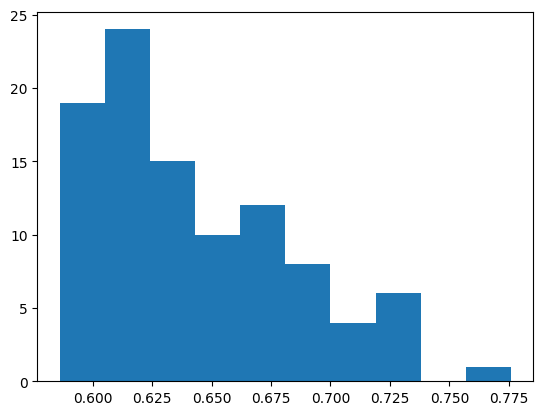

In [46]:
plt.hist(accs)
print(accs.shape)
print(len(files))

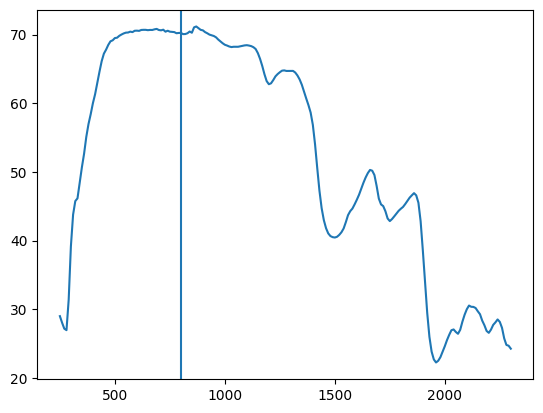

In [138]:
plt.plot(wavelengthb, X[0])
plt.axvline(800)

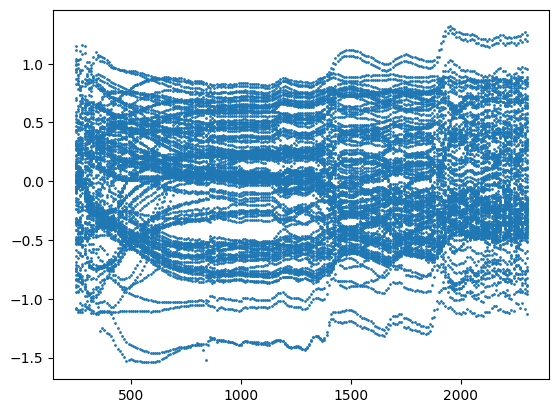

In [139]:
#test_imagesb = test_images.reshape(119,206)
#test_imagesb -= test_images.mean(0)
plt.scatter(wavelength, test_images, s=1)

(24514,)


array([2300., 2290., 2280., ...,  270.,  260.,  250.])

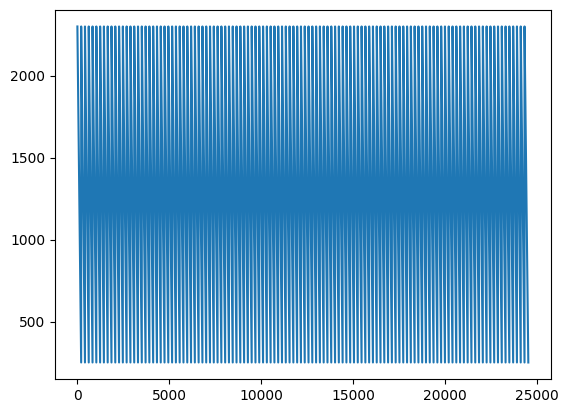

In [140]:
print(test_images.shape)
wavelength = np.tile(wavelengthb, 119)
plt.plot(wavelength)
wavelength

(3, 119, 206) (206,) (206,)


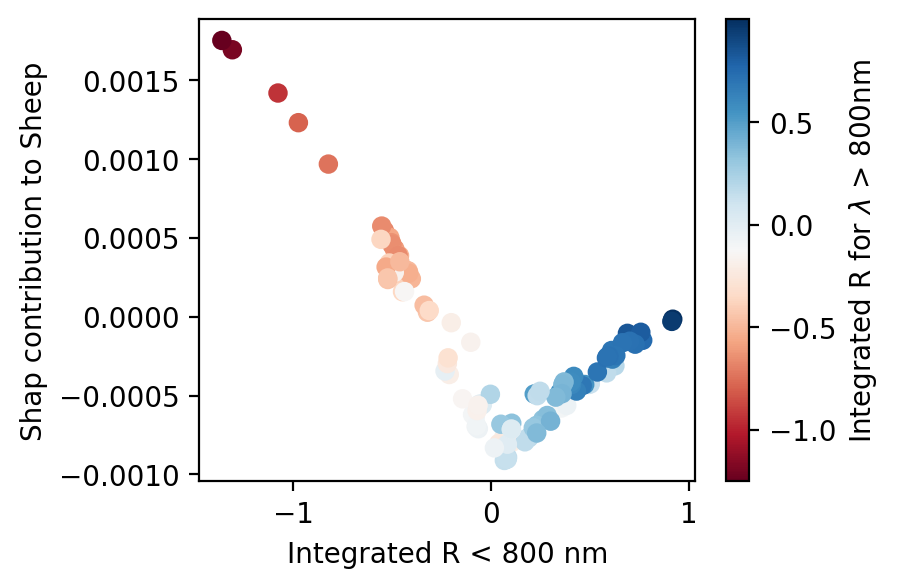

In [164]:
wlmasking = wavelengthb > 800
wlmasking1 = wavelengthb < 800
sp = shap_values.reshape(3, 119, 206)
ti = test_images.reshape(119, 206)
print(sp.shape, wlmasking.shape, wlmasking1.shape)
x = np.mean(ti[:, wlmasking], axis=-1)
y = np.mean(sp[:, :, wlmasking1], axis=-1)
z = np.mean(ti[:, wlmasking1], axis=-1)
fig = plt.figure(figsize=(4,3), dpi=200)
plt.scatter(z, y[1], c=x, cmap="RdBu")
plt.xlabel("Integrated R < 800 nm")
plt.ylabel("Shap contribution to Sheep")
cb= plt.colorbar()
cb.set_label("Integrated R for $\lambda$ > 800nm")

IndexError: boolean index did not match indexed array along dimension 0; dimension is 99 but corresponding boolean dimension is 119

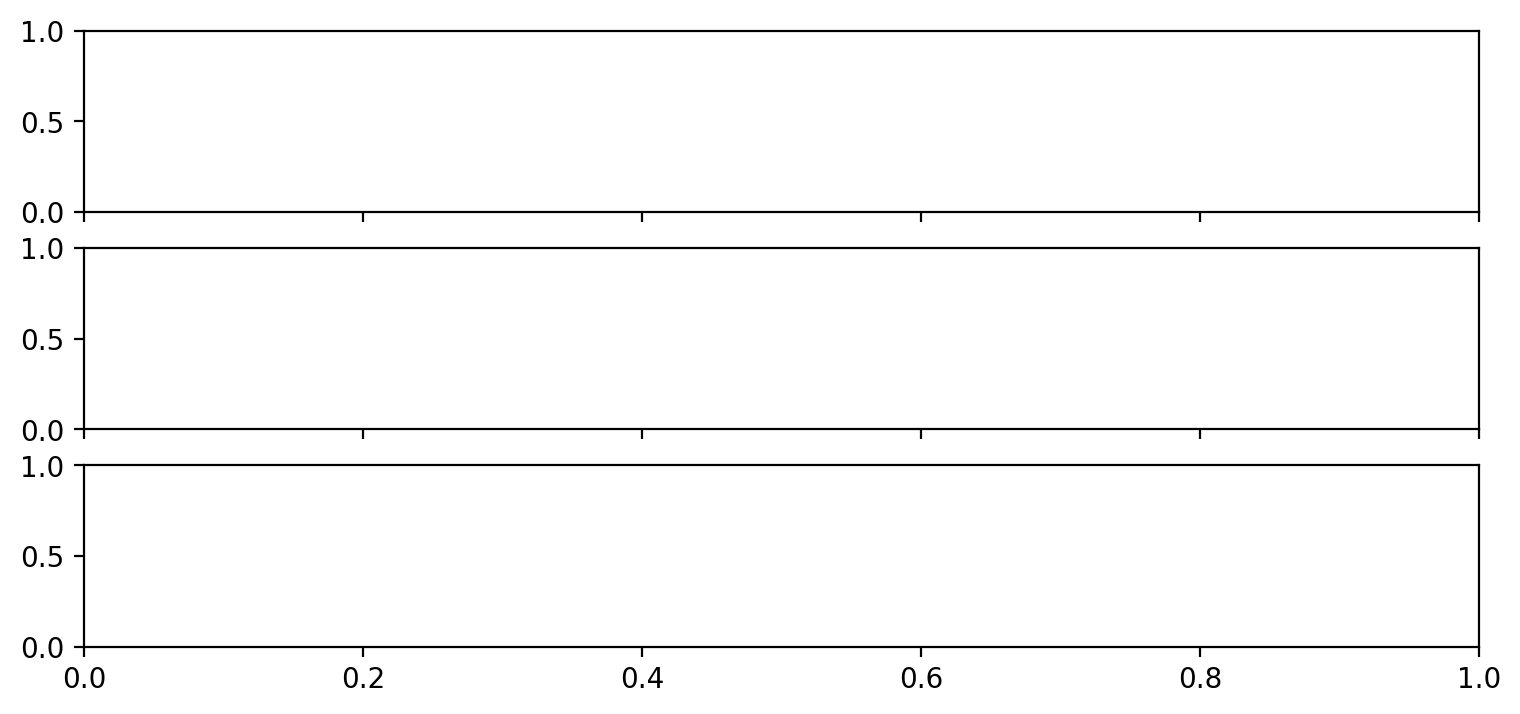

In [44]:
fig, axs = plt.subplots(3,1, figsize=(9,4), sharex=True, sharey=False, dpi=200)
norm = plt.Normalize()
mask = labels==5
print(accs[mask])
ti = test_images.reshape(119, -1)
ti = ti[mask]
ti = norm(ti.flatten())#.reshape(test_images.shape[0], -1))
colors = plt.cm.RdBu(ti)
sp2 = shap_values.copy().reshape(3, 119, -1)
print(wavelength.shape)
wl = wavelength.reshape(119, -1)
sp2[:, :, ::6] /= 2
spd = sp2[:, mask].reshape(3, -1)
wl = wl[mask].flatten()
#for i in range(len(shap_values[0])):
axs[0].scatter(wl, spd[0], alpha=0.4, s=1, c=colors)
axs[1].scatter(wl, spd[1], alpha=0.4, s=1, c=colors)
axs[2].scatter(wl, spd[2], alpha=0.4, s=1, c=colors)

(3, 24514)
(99,)


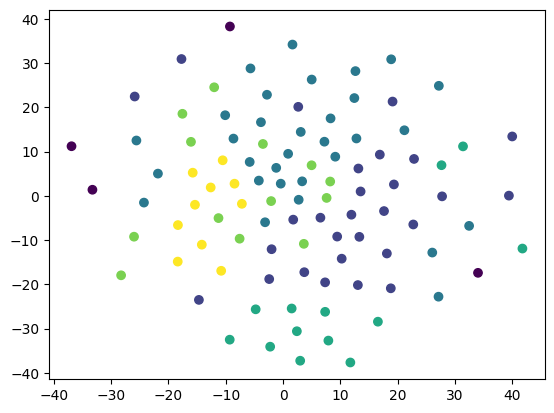

In [56]:
print(sp2.shape)
sp3 = raw_shaps.reshape(-1, 3, 119, 206)
sp3 = sp3[:,:,0,:].reshape(99, -1)
from sklearn.manifold import TSNE
proj = TSNE(2, perplexity=30)
p = proj.fit_transform(sp3)
from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(6)
labels = model.fit_predict(sp3)
plt.scatter(*p.T, c=labels)
print(labels.shape)